In [1]:
# general
import warnings
from tqdm import tqdm
from datasets import load_dataset
import time
from collections import defaultdict
from transforms.PermuteImage import PermuteImage
from os.path import isfile

# ML
import numpy as np
import pandas as pd

# visual
import matplotlib.pyplot as plt
import seaborn as sns

# # DL
import torch
from torch.nn import Module
import cv2
from torch import nn, Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from torchvision import transforms, models
from modules.HeadlessPretrainedModule import HeadlessPretrainedModule
from modules.CustomModule import CustomModule
from modules.CustomModule import CustomModule2
from transforms.Transform_Builder import Transform_Builder
from modules.VitModule import VitModule

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42

In [2]:
dataset = load_dataset("cats_vs_dogs", trust_remote_code=True, verification_mode='no_checks')
dataset = dataset['train']

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

In [3]:
splitted_dataset = dataset.train_test_split(test_size=0.05, shuffle=True, seed=SEED)
train_val_dataset = splitted_dataset['train'].train_test_split(test_size=0.05, shuffle=True, seed=SEED)

In [4]:
train = train_val_dataset['train']
val = train_val_dataset['test']
test = splitted_dataset['test']

In [22]:
img = PermuteImage.permute_all(np.array(test[0]["image"]))

In [31]:
from itertools import permutations


f = permutations(range(9), 9)

In [7]:
x = np.arange(9)


In [8]:
def create_n_premutations(arr: np.array, n:int ,seed):
    np.random.seed(seed)
    permutations_set = set()
    while len(permutations_set) < n:
        perm = tuple(np.random.permutation(arr))
        permutations_set.add(perm)
    return list(permutations_set)

In [11]:
permutations_set = create_n_premutations(x, 9, SEED)

In [27]:
premutation_dict = {}
tiles_num = 9
tiles_per_row = int(np.sqrt(tiles_num))
premutation_dict["vertical_swap"] = np.arange(tiles_num).reshape(tiles_per_row,tiles_per_row)[:,np.arange(tiles_per_row)[::-1]].flatten()
premutation_dict["horizontal_swap"] = np.arange(tiles_num).reshape(tiles_per_row,tiles_per_row)[np.arange(tiles_per_row)[::-1],:].flatten()

In [29]:
premutation_dict.values()

dict_values([array([2, 1, 0, 5, 4, 3, 8, 7, 6]), array([6, 7, 8, 3, 4, 5, 0, 1, 2])])

In [31]:
igm1 =test[0]["image"]

In [37]:
    .pil_to_tensor(igm1)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 0>:1                                                                              │
│                                                                                                  │
│ ❱ 1 torch.pil_to_tensor(igm1)                                                                    │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: module 'torch' has no attribute 'pil_to_tensor'

In [42]:
images = PermuteImage.permute_by_defined_premutations(transforms.PILToTensor()(igm1), premutation_dict.values())

In [13]:
permutations_set

[(8, 5, 1, 7, 0, 2, 4, 3, 6),
 (1, 5, 4, 8, 0, 7, 6, 3, 2),
 (2, 0, 4, 8, 7, 6, 5, 1, 3),
 (0, 5, 2, 6, 3, 7, 4, 1, 8),
 (7, 2, 5, 8, 3, 1, 0, 4, 6),
 (7, 1, 5, 0, 8, 2, 4, 3, 6),
 (8, 2, 0, 6, 7, 5, 3, 1, 4),
 (1, 7, 6, 2, 8, 0, 3, 4, 5),
 (0, 1, 5, 3, 4, 7, 8, 6, 2)]

In [172]:
def permute_all(img, permutations_set, num_tiles=9):
    permuted_imgs = []
    tiles_per_row = int(np.sqrt(num_tiles))
    x = int(img.shape[0] // tiles_per_row * tiles_per_row)
    y = int(img.shape[1] // tiles_per_row * tiles_per_row)
    img = img[:x, :y, :]
    height, width, channels = img.shape
    tile_width = int(width // tiles_per_row)
    tile_height = int(height // tiles_per_row)
    tiled_array = img.reshape(tiles_per_row, tile_height, tiles_per_row, tile_width, channels)
    tiled_array = tiled_array.swapaxes(1, 2)
    tiles = tiled_array.reshape(num_tiles, tile_height, tile_width, channels)
    for permutation in permutations_set:
        premuted_tiles= tiles[permutation, :]
        tiled_array = premuted_tiles.reshape(tiles_per_row, tiles_per_row, tile_height, tile_width, channels)
        tiled_array = tiled_array.swapaxes(1, 2)
        permuted_img = tiled_array.reshape(height, width, channels)
        permuted_imgs.append(permuted_img)
    return torch.stack(permuted_imgs)

In [117]:
np.concatenate([np.array([]),np.array((3, 3, 4))])

array([3., 3., 4.])

In [251]:
test_set = test.with_transform(Transform_Builder.build(224))

In [162]:
igm1 =test_set[:]["image"][0]



In [164]:
igm1.permute(1,2,0).shape

torch.Size([100, 100, 3])

In [161]:
np.array(test[0]["image"]).shape

(336, 448, 3)

In [125]:
img = test[0]["image"]
f = permute_all(np.array(img), permutations_set, num_tiles=9)

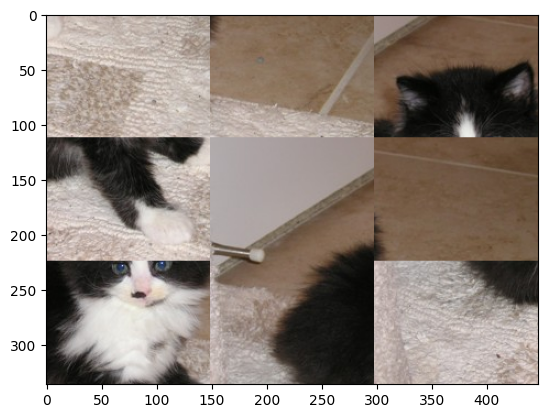

In [134]:
plt.imshow(d[0])

In [140]:
f = None
for img in test_set[:3]["image"]:
    if f is None:
        f = permute_all(np.array(img), permutations_set, num_tiles=9)
    else:
        d = permute_all(np.array(img), permutations_set, num_tiles=9)
        f= np.vstack([f,d])
    

In [149]:
for i in test_set[:3].item():
    print(i)

image
labels


In [252]:
permuted_images = [permute_all(img.permute(1,2,0), permutations_set, num_tiles=9) for img in test_set[:]["image"]]
g = torch.stack(permuted_images)

In [178]:
g= torch.stack(permuted_images)

In [258]:
g  = torch.permute(g,(0,1,4,2,3))

In [259]:
g[:,0,:].shape

torch.Size([1172, 3, 222, 222])

In [179]:
pretrained_model = HeadlessPretrainedModule(pretrained_model = models.resnet50(pretrained=True), device=device)
pretrained_model = pretrained_model.to(device)
if isfile("./pretrained_model.pth"):
    pretrained_model.load_state_dict(torch.load("./pretrained_model.pth"))
else:
    lr = 5e-3
    num_epochs = 5

    optimizer = torch.optim.SGD(pretrained_model.parameters(), lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    pretrained_model.start_train(criterion, optimizer, dataloaders)
    torch.save(pretrained_model.state_dict(), "./pretrained_model.pth")

In [182]:
num_permutations = 9

In [185]:
g[:,0,:].shape

torch.Size([1172, 99, 99, 3])

In [186]:
test_set["labels"]

tensor([0, 0, 1,  ..., 0, 1, 1])

In [202]:
from datasets import Dataset
Dataset.from_dict({"image" : g[:,0,:], "labels": test_set["labels"] })

Dataset({
    features: ['image', 'labels'],
    num_rows: 1172
})

In [188]:
from torch.utils.data import TensorDataset

In [218]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {'image': self.images[idx], 'labels': self.labels[idx]}

In [214]:
f= CustomDataset(g[:,0,:],test_set["labels"])

In [227]:
g[0,i,:]

torch.Size([1172, 3, 99, 99])

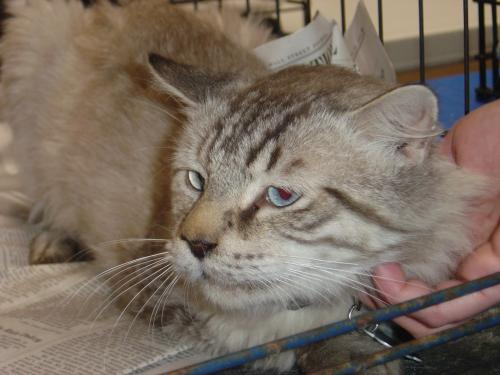

In [244]:
test[1]["image"]

In [257]:
g[1,0,:].shape

torch.Size([222, 222, 3])

In [254]:
def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

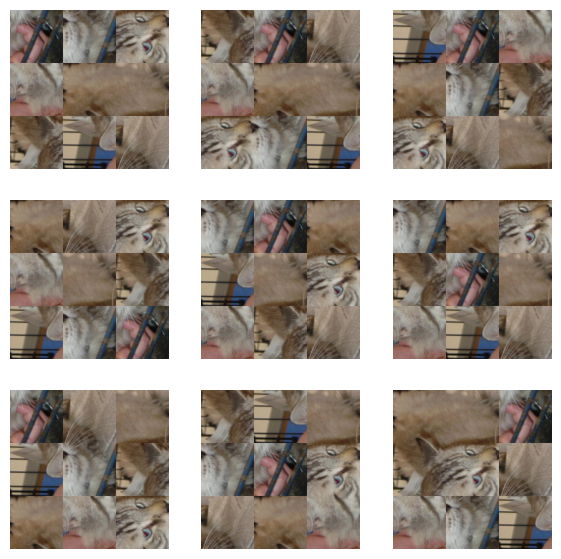

In [260]:
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.flatten()
for i in range(9):
    # img = np.transpose(img, (1, 2, 0))  # Transpose to (H, W, C)
    axes[i].imshow(torch.permute(denormalize(g[1,i,:],mean, std),(2,1,0)))
    axes[i].axis('off')
plt.show();

In [261]:
results = {"Permutation_Type": [], "Accuracy": []}
for premutation in range(num_permutations):
    premuted_dataloader = DataLoader(CustomDataset(g[:,premutation,:],test_set["labels"]), batch_size=32, drop_last=True, num_workers=0)
    pretrained_model.predict_data(premuted_dataloader)
    results["Permutation_Type"].append(premutation)
    results["Accuracy"].append(pretrained_model.test_acc)

Test Acc: 0.906200
Test Acc: 0.922700
Test Acc: 0.926200
Test Acc: 0.914100
Test Acc: 0.912300
Test Acc: 0.916700
Test Acc: 0.922700
Test Acc: 0.930600
Test Acc: 0.959200


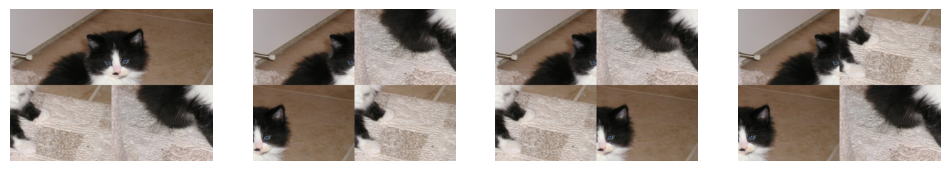

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    # img = np.transpose(img, (1, 2, 0))  # Transpose to (H, W, C)
    axes[i].imshow(img[i])
    axes[i].axis('off')
plt.show()

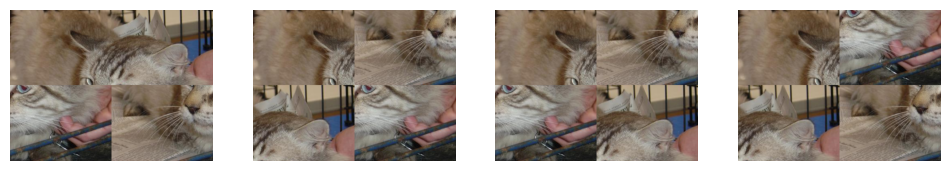

In [24]:
img = PermuteImage.permute_all(np.array(test[1]["image"]))
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    # img = np.transpose(img, (1, 2, 0))  # Transpose to (H, W, C)
    axes[i].imshow(img[i])
    axes[i].axis('off')